<a href="https://colab.research.google.com/github/rajatha94/capnet-GAN/blob/master/capnet_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import os
import glob
from tqdm import tqdm

from keras import layers, models, optimizers
from keras import backend as K
from keras import callbacks
from keras.utils import to_categorical
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import Input, Dense, Flatten, Reshape, Dropout, Lambda, Multiply, Concatenate
from keras.layers import BatchNormalization, ZeroPadding2D, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential 
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
import tensorflow as tf
from tensorflow.python.client import device_lib
import numpy as np

import skimage
from skimage import data, color, exposure
from skimage.transform import resize
import matplotlib.pyplot as plot
%matplotlib inline

realDiscriminatorLoss = []
generatedDiscriminatorLoss = []
totalDiscriminatorLossandAcc = []
generatorLoss = []

Using TensorFlow backend.


In [0]:
def loadDataset(dataset, width, height, channels):
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = (x_train.astype(np.float32) - 127.5) / 127.5
  x_train = np.expand_dims(x_train, axis=3)
  img_rows = width
  img_cols = height
  channels = channels
  img_shape = [img_rows, img_cols, channels]
  return x_train, img_shape

In [4]:
dataset, shape = loadDataset('mnist', 28, 28, 1)
print('Dataset: ' + str(dataset.shape))
print('Image Data: ' + str(shape))

11493376/11490434 [==============================] - 2s 0us/step
Dataset: (60000, 28, 28, 1)
Image Data: [28, 28, 1]


In [0]:
def squash(vectors, axis=-1):
  squaredNorm = K.sum(K.square(vectors), axis, keepdims=True)
  scale = squaredNorm / (1 + squaredNorm) / K.sqrt(squaredNorm + K.epsilon())
  return scale * vectors

In [0]:
# Implementation of Discriminator
def buildDiscriminator():
  image = Input(shape=(shape[0], shape[1], shape[2]))

  # First Conv2D layer
  d = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', name='firstConvLayer')(image)
  d = LeakyReLU()(d)
  d = BatchNormalization(momentum=0.8)(d)

  # Capsule network implementation (Primarycaps and Digitcaps)
  # Primarycaps
  d = Conv2D(filters=8 * 32, kernel_size=9, strides=2, padding='valid', name='primarycapsConvLayer')(d)
  d = Reshape(target_shape=[-1, 8], name='primarycapsReshapeLayer')(d)
  d = Lambda(squash, name='primarycapsSquashingFunction')(d)
  d = BatchNormalization(momentum=0.8)(d)
  # Digitcaps
  d = Flatten()(d)
  uCap = Dense(160, kernel_initializer='he_normal', bias_initializer='zeros', name='uCapDigitcaps')(d)
  couplingCoefficient = Activation('softmax', name='softmaxLayer1')(uCap)
  couplingCoefficient = Dense(160)(couplingCoefficient)
  x = Multiply()([uCap, couplingCoefficient])
  layer1 = LeakyReLU()(x)
  couplingCoefficient = Activation('softmax', name='softmaxLayer2')(layer1) 
  couplingCoefficient = Dense(160)(couplingCoefficient)
  x = Multiply()([uCap, couplingCoefficient])
  layer2 = LeakyReLU()(x)
  couplingCoefficient = Activation('softmax', name='softmaxLayer3')(layer2) 
  couplingCoefficient = Dense(160)(couplingCoefficient) 
  x = Multiply()([uCap, couplingCoefficient])
  layer3 = LeakyReLU()(x)
  pred = Dense(1, activation='sigmoid')(layer3)
  return Model(image, pred)

In [0]:
discriminator = buildDiscriminator()
discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

In [0]:
# Implementation of Generator (Similar to DCGAN Architecture)
def buildGenerator():
  noise = Input(shape=(100,))
  x = Dense(128 * 7 * 7, activation="relu")(noise)
  x = Reshape((7, 7, 128))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = UpSampling2D()(x)
  x = Conv2D(128, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = UpSampling2D()(x)
  x = Conv2D(64, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Conv2D(1, kernel_size=3, padding="same")(x)
  output = Activation("tanh")(x)
  return Model(noise, output)

In [0]:
generator = buildGenerator()
generator.summary()
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [0]:
# Creating combined model stacking generator and discriminator (used for training generator)
# Input random noise for generator
noise = Input(shape=(100,))
imageGenerated = generator(noise)
discriminator.trainable = False
# Keeping discriminator static
valid = discriminator(imageGenerated)
# Noise as input => generates images => determines validity 
combined = Model(noise, valid)
combined.summary()
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [0]:
def train(epochs, batch_size, interval):

  half_batch = int(batch_size / 2)
  for epoch in range(epochs):
    randomBatch = np.random.randint(0, dataset.shape[0], half_batch)
    # Training the Discriminator 
    realImages = dataset[randomBatch]
    disRealLoss = discriminator.train_on_batch(realImages, np.ones((half_batch, 1))*0.85)
    realDiscriminatorLoss.append(disRealLoss)

    randomNoise = np.random.normal(0, 1, (half_batch, 100))
    generatedImages = generator.predict(randomNoise) # generate a half batch of new images
    disGenLoss = discriminator.train_on_batch(generatedImages, np.zeros((half_batch, 1)))
    generatedDiscriminatorLoss.append(disGenLoss)

    totalDisLossAcc = 0.5 * np.add(disRealLoss, disGenLoss)
    totalDiscriminatorLossandAcc.append(totalDisLossAcc)

    # Training the Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    genLoss = combined.train_on_batch(noise, np.ones((batch_size, 1)))
    generatorLoss.append(genLoss)

    #Progress
    print ("%d [Discriminator loss: %f, Accuracy: %.3f%%] [Generator loss: %f]" % (epoch, totalDisLossAcc[0], 100*totalDisLossAcc[1], genLoss))

    if epoch % interval == 0:
      r, c = 5, 5
      noise = np.random.normal(0, 1, (r * c, 100))
      generatedImages = generator.predict(noise)
      generatedImages = 0.5 * generatedImages + 0.5
      fig, axis = plot.subplots(r, c)
      count = 0
      # Creating output images
      for i in range(r):
        for j in range(c):
          axis[i,j].imshow(generatedImages[count, :,:,0], cmap='gray')
          axis[i,j].axis('off')
          count += 1
      plot.show()
      plot.close()

In [0]:
train(4000, 32, 1000)

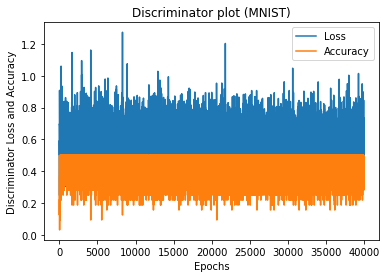

In [15]:
plot.plot(totalDiscriminatorLossandAcc)
plot.title('Discriminator plot (MNIST)')
plot.xlabel('Epochs')
plot.ylabel('Discriminator Loss and Accuracy')
plot.legend(['Loss', 'Accuracy'])
plot.show()

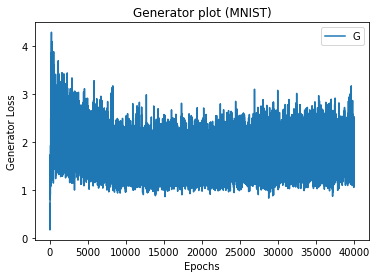

In [16]:
plot.plot(generatorLoss)
plot.title('Generator plot (MNIST)')
plot.xlabel('Epochs')
plot.ylabel('Generator Loss')
plot.legend('Gen Loss')
plot.show()